# Motion Deblur Acquisition Notebook

In [1]:
# Magic Functions
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Misc imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import sleep
import sys, os, time, datetime

# lwl imports
from libwallerlab.utilities import io
from libwallerlab.utilities import display
from libwallerlab.utilities import roi
import libwallerlab.acquisition.hardware as hardware
import libwallerlab.acquisition.acquisition as acquisition
import libwallerlab.projects.motiondeblur as md

## Create Hardware Controllers

In [2]:
# Define COM ports
led_array_port = "COM7"
xy_stage_port = "COM5"
camera_name = 'pco'

# Delete old devices
if 'led_controller' in locals():
    led_controller.unloadDevice()
    
if 'pos_controller' in locals():
    pos_controller.unloadDevice()

if 'cam_controller' in locals():
    cam_controller.unloadDevice()

# Create LED controller interface
led_controller = hardware.LedArrayController(led_array_port)
led_controller.setupCameraTriggering(pin_index=0)
led_controller.setupMotionStageTriggering(pin_index=1, delay_ms=1)
led_controller.trigger_mode = 'software'
led_controller.clear()

# Create position controller interface
pos_controller = hardware.PositionController(xy_stage_port)

# Create camera controller object
cam_controller = hardware.CameraController(camera_name)
    
# Set up hardware triggering
cam_controller.trigger_mode = 'hardware'
cam_controller.trigger_pin = 0

pos_controller.trigger_mode = 'hardware'
pos_controller.trigger_pin = 1

# Make a list
hardware_controller_list = [led_controller, cam_controller, pos_controller]

# Illuminate the light source as verification
led_controller.bf()

Micro-manager was loaded sucessfully!


## Create data output directory

In [3]:
out_dir = 'D:\\Zack\\' + datetime.date.today().strftime("%m-%d-%y") +'-MotionDeblur\\'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Define System Metadata

In [4]:
# Define LED positions using actual distances from sample
array_z_distance_mm = 60.0

# Load quasi-dome positions
led_controller.setArrayDistance(array_z_distance_mm)
source_list_cart = led_controller.getLedPositions()
source_list_na_design = io.cartToNa(source_list_cart)

# Define system metadata
sys_metadata_dict = {
    'objective' :{'na': .25, 'mag' : 10}, # remember to set system_mag to 2. for B (front port)
    'system' : {'mag': 1},
    'illumination' : {"device_name" : led_controller.device_name, "spectrum" : {"center" : {'b' : 0.480, "g" : 0.532, "r" : 0.625}}, 
                      "z_distance_mm" : array_z_distance_mm, "state_list" : {"design" : source_list_na_design, 'units' : 'na'}, 'bit_depth' : led_controller.device_name, "device_type" : led_controller.device_type},
    'position' : {"device_name" : "h117", "state_list" : {'units' : 'mm'}, "device_type" : "xy_stage"}
}

# Create metadata object
sys_metadata = io.Metadata(from_dict=sys_metadata_dict)

# Assign wavelengths
sys_metadata.illumination.spectrum.center = led_controller.color_channel_center_wavelengths

# Set up camera
if camera_name == "pco":
    sys_metadata.camera.pixel_size_um = 6.5
    sys_metadata.camera.is_color = False
    sys_metadata.camera.device_name = camera_name
    sys_metadata.camera.port = 'side'
    sys_metadata.system.mag = 1.0
    sys_metadata.camera.transpose = False
    sys_metadata.camera.flip_x = True
    sys_metadata.camera.flip_y = False
elif camera_name == "pco_color":
    sys_metadata.camera.pixel_size_um = 6.5 * 2
    sys_metadata.camera.is_color = True
    sys_metadata.camera.device_name = 'pco'
    sys_metadata.camera.port = 'front'
    sys_metadata.system.mag = 1.934
    sys_metadata.camera.transpose = False
    sys_metadata.camera.flip_x = False
    sys_metadata.camera.flip_y = True
    sys_metadata.camera.bayer_coupling_matrix = None

    cam_controller.bayer_coupling_matrix = sys_metadata.camera.bayer_coupling_matrix
    cam_controller.is_color = True
elif camera_name == 'optimos':
    sys_metadata.camera.pixel_size_um = 4.54
    sys_metadata.camera.is_color = True
    sys_metadata.camera.bayer_coupling_matrix = bayer_coupling_matrix
    sys_metadata.system.mag = 2.0
    sys_metadata.camera.port = 'front'
    sys_metadata.camera.device_name = camera_name
elif camera_name == 'retiga':
    sys_metadata.camera.pixel_size_um = 4.54
    sys_metadata.camera.is_color = False
    sys_metadata.system.mag = 1.0
    sys_metadata.camera.port = 'side'
    sys_metadata.camera.device_name = camera_name
else:
    raise ValueError("No camera found!")

# Calculate effective pixel size
sys_metadata.system.eff_pixel_size_um = sys_metadata.camera.pixel_size_um / (sys_metadata.objective.mag * sys_metadata.system.mag)

# Print system metadata
print(sys_metadata)

# Set up led array hardware to use this metadata
led_controller.setNa(sys_metadata.objective.na)
led_controller.setArrayDistance(sys_metadata.illumination.z_distance_mm)

# Set up joystick
pos_controller.setJoystickFlip(True, False) # up is +y, right is +x

# Print information about sampling
sys_metadata.checkSampling()

# Display brightfield pattern for alignment
led_controller.bf()

focus: device_name: None, device_type: None, state_list: design: None, calibrated: None, grouping: None, units: None, velocity_mm_s: None, acceleration_mm_s2: None
pupil: device_name: None, device_type: None, state_list: design: None, calibrated: None, grouping: None, units: None
position: device_name: h117, device_type: xy_stage, state_list: design: None, calibrated: None, grouping: None, units: mm, velocity_mm_s: None, acceleration_mm_s2: None, units: mm
illumination: device_name: laser, device_type: led_array, state_list: design: [[1.66666667e-06 1.66666667e-06]], calibrated: None, grouping: None, units: na, z_distance_mm: 60.0, bit_depth: laser, is_color: False, spectrum: center: {'w': 0.405}, full: None, units: um
camera: roi: Roi(), transpose: False, flip_x: True, flip_y: False, pixel_size_um: 6.5, is_color: False, bayer_coupling_matrix: None, device_name: pco, bit_depth: 16, is_demosaiced: False, port: side
objective: mag: 10, na: 0.25
sample: roi: Roi(), name: None, size_mm: No

# Live Viewer

<IPython.core.display.Javascript object>


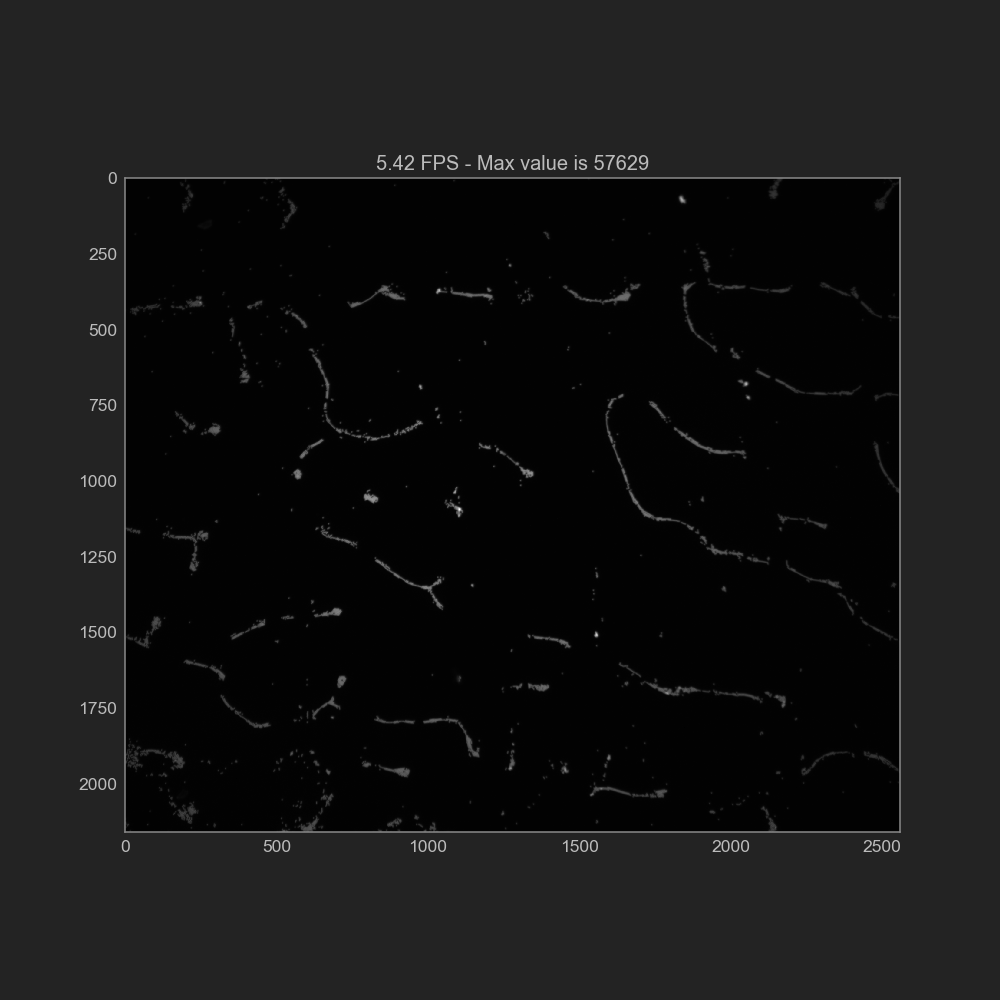

In [5]:
# Illuminate
led_controller.command('bf')

# Exposure
exposure_time_ms = 100

# Start live view
cam_controller.liveView(transpose=sys_metadata.camera.transpose, exposure_ms=exposure_time_ms,
                        flip_x=sys_metadata.camera.flip_x,
                        flip_y=sys_metadata.camera.flip_y, figsize=(10,10), contrast_type='fit')

# pos_controller.zero()

## Set up Acquisition

In [39]:
pos_controller.reloadDevice()
pos_controller.zero()
sys_metadata.sample.name = 'beads_raster'
sample_size_0 = (20, 25) #(22, 28)
f = 0.8

led_controller.reloadDevice()
pos_controller.reloadDevice()

if sys_metadata.camera.is_color:
    sys_metadata.sample.name += '_color'

# Determine FOV size
ps = sys_metadata.system.eff_pixel_size_um
if sys_metadata.camera.is_color:
    ps /= 2
    
if sys_metadata.camera.transpose:
    fov = np.asarray((cam_controller.getImageHeight() * ps, cam_controller.getImageWidth() * ps)) / 1000.
else:
    fov = np.asarray((cam_controller.getImageWidth() * ps, cam_controller.getImageHeight() * ps)) / 1000.
    
# Round up sample size
sys_metadata.sample.size_mm = np.ceil(np.asarray(sample_size_0) / np.asarray((f * fov[0], f * fov[1]))) * np.asarray((f * fov[0], f * fov[1]))

# Acquisition

## Background Image Capture

<IPython.core.display.Javascript object>


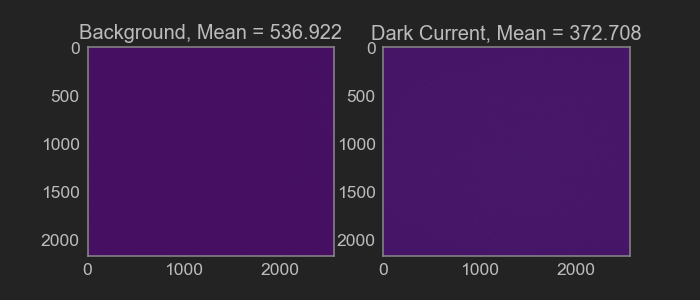

Text(0.5, 1.0, 'Dark Current, Mean = 372.708')

In [40]:
n_avg = 10
sample_free_offset = (0, -25)
exposure_bg = 0.1
# pos_controller.zero()
pos_controller.goToPosition(sample_free_offset, blocking=True)
cam_controller.setExposure(exposure_bg)
led_controller.bf()
time.sleep(1)
img_bg = cam_controller.snap(transpose=sys_metadata.camera.transpose,
                             flip_x=sys_metadata.camera.flip_x,
                             flip_y=sys_metadata.camera.flip_y)

led_controller.clear()

# Capture dark current image
img_dc = cam_controller.snap(transpose=sys_metadata.camera.transpose,
                             flip_x=sys_metadata.camera.flip_x,
                             flip_y=sys_metadata.camera.flip_y)

# Perform averaging
for _ in range(n_avg - 1):
    time.sleep(0.1)
    img_dc += cam_controller.snap(transpose=sys_metadata.camera.transpose,
                                 flip_x=sys_metadata.camera.flip_x,
                                 flip_y=sys_metadata.camera.flip_y)
# Normalize
img_dc = img_dc / n_avg

# Go back home
pos_controller.goToPosition((0,0))

plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(img_bg)
plt.title('Background, Mean = %g' % np.mean(img_bg))
plt.subplot(122)
plt.imshow(img_dc)
plt.title('Dark Current, Mean = %g' % np.mean(img_dc))

## Stop and Stare Acquisition

In [41]:
sns_options = acquisition.StopAndStareAcquisitionOptions(opts_dict = {"illumination_color" : {'w' : 255}, 
                                                                      "trigger_mode" : 'software',
                                                                      "frame_spacing_mm" : (f * fov[0], f * fov[1]), # y,x
                                                                      "object_size_mm" : sys_metadata.sample.size_mm, # y,x
                                                                      "settle_time_s" : 0.5,
                                                                      "initial_auto_exposure" : False})

# Create Acquisition Object
sns_acq = acquisition.StopAndStareAcquisition(hardware_controller_list, sys_metadata, options=sns_options)

# Acquire
res = sns_acq.acquire(exposure_time_ms=100)

# Save background and dark current
res.background = img_bg
res.dark_current = img_dc

# Reset Stage
pos_controller.goToPosition((0,0))

# Save 
meta = res.save(out_dir, header=sys_metadata.sample.name + '_stopandstare', bit_depth=16)

del res

Image size requires 16 x 23 images
Acquired 1 of 368 frames
Acquired 2 of 368 frames
Acquired 3 of 368 frames
Acquired 4 of 368 frames
Acquired 5 of 368 frames
Acquired 6 of 368 frames
Acquired 7 of 368 frames
Acquired 8 of 368 frames
Acquired 9 of 368 frames
Acquired 10 of 368 frames
Acquired 11 of 368 frames
Acquired 12 of 368 frames
Acquired 13 of 368 frames
Acquired 14 of 368 frames
Acquired 15 of 368 frames
Acquired 16 of 368 frames
Acquired 17 of 368 frames
Acquired 18 of 368 frames
Acquired 19 of 368 frames
Acquired 20 of 368 frames
Acquired 21 of 368 frames
Acquired 22 of 368 frames
Acquired 23 of 368 frames
Acquired 24 of 368 frames
Acquired 25 of 368 frames
Acquired 26 of 368 frames
Acquired 27 of 368 frames
Acquired 28 of 368 frames
Acquired 29 of 368 frames
Acquired 30 of 368 frames
Acquired 31 of 368 frames
Acquired 32 of 368 frames
Acquired 33 of 368 frames
Acquired 34 of 368 frames
Acquired 35 of 368 frames
Acquired 36 of 368 frames
Acquired 37 of 368 frames
Acquired 38 

Acquired 308 of 368 frames
Acquired 309 of 368 frames
Acquired 310 of 368 frames
Acquired 311 of 368 frames
Acquired 312 of 368 frames
Acquired 313 of 368 frames
Acquired 314 of 368 frames
Acquired 315 of 368 frames
Acquired 316 of 368 frames
Acquired 317 of 368 frames
Acquired 318 of 368 frames
Acquired 319 of 368 frames
Acquired 320 of 368 frames
Acquired 321 of 368 frames
Acquired 322 of 368 frames
Acquired 323 of 368 frames
Acquired 324 of 368 frames
Acquired 325 of 368 frames
Acquired 326 of 368 frames
Acquired 327 of 368 frames
Acquired 328 of 368 frames
Acquired 329 of 368 frames
Acquired 330 of 368 frames
Acquired 331 of 368 frames
Acquired 332 of 368 frames
Acquired 333 of 368 frames
Acquired 334 of 368 frames
Acquired 335 of 368 frames
Acquired 336 of 368 frames
Acquired 337 of 368 frames
Acquired 338 of 368 frames
Acquired 339 of 368 frames
Acquired 340 of 368 frames
Acquired 341 of 368 frames
Acquired 342 of 368 frames
Acquired 343 of 368 frames
Acquired 344 of 368 frames
A

## Motion Deblur Acquisition

In [50]:
# Re-initialize position controller
pos_controller.reloadDevice()
pos_controller.goToPositionRapid((0,0), blocking=True)
pos_controller.setAcceleration(8e2)
# pos_controller.jerk = 7423223
pos_controller.jerk = 7423223
pos_controller.trigger_pulse_width_us = 2000

# Re-initialize led controller
led_controller.reloadDevice()
led_controller.bf()
led_controller.command_debug = False
pos_controller.command('SS 1')
pos_controller.command('ENCODER X 0')
pos_controller.command('ENCODER Y 0')
pos_controller.command('ENCW X 100')
pos_controller.command('ENCW Y 100')

'0\r'

In [ ]:
md_options = acquisition.MotionDeblurAcquisitionOptions(opts_dict = {"illumination_color" :{'w' : 127},
                                                                     "trigger_mode" : 'hardware',
                                                                     "trigger_feedback_type" : 'two_way',
                                                                     "frame_spacing_mm" : (f * fov[0], f * fov[1]), # x,y
                                                                     "object_size_mm" : sys_metadata.sample.size_mm, # x,y
                                                                     "saturation_factor" : 0.5, #1/8
                                                                     "extra_run_up_time_s" : 0.1,
                                                                     "kernel_pulse_count" : 10,
                                                                     "velocity_mm_s" : 25,
                                                                     "motion_path_type" : "raster",
                                                                     "blur_vector_method" : "coded",
                                                                     'debug' : False,
                                                                     "use_l1_distance_for_motion_calculations" : True,
                                                                     "segment_delay_s" : 0.0})

# Generate acquisition object using options above
md_acq = acquisition.MotionDeblurAcquisition(hardware_controller_list, sys_metadata, options=md_options)

# Create dataset to populate
res = io.Dataset()

# Acquire
md_acq.preAcquire()
md_acq.acquire()
md_acq.postAcquire(res, reset_devices=True)

# Save background and dark current
res.background = img_bg
res.dark_current = img_dc

# Save results
meta = res.save(out_dir, header=sys_metadata.sample.name + '_' + md_options.blur_vector_method + '_' + md_options.motion_path_type + '_' + str(md_options.kernel_pulse_count))

Image size requires 16 x 23 images
Generated motion pathway with 16 linear segments
-0.8417499999999993
-0.8417499999999993
-0.8417499999999993
-0.8417499999999993
-0.8417500000000002
-0.8417500000000002
-0.8417500000000002
-0.8417500000000002
-0.8417500000000002
-0.84175
-0.84175
-0.84175
-0.84175
-0.8417500000000002
-0.8417500000000002
-0.8417500000000002
-0.8417500000000002
-0.8417500000000002
-0.8417499999999993
-0.8417499999999993
-0.8417499999999993
-0.8417499999999993
-0.8417499999999993
0.8417499999999993
0.8417499999999993
0.8417499999999993
0.8417499999999993
0.8417500000000002
0.8417500000000002
0.8417500000000002
0.8417500000000002
0.8417500000000002
0.84175
0.84175
0.84175
0.84175
0.8417500000000002
0.8417500000000002
0.8417500000000002
0.8417500000000002
0.8417500000000002
0.8417500000000002
0.8417499999999993
0.8417499999999993
0.8417499999999993
0.8417499999999993
-0.8417499999999993
-0.8417499999999993
-0.8417499999999993
-0.8417499999999993
-0.8417500000000002
-0.8417

Finished fast Sequence 
-==-

Finished linear segment 2
Starting linear segment 3 which has 23 frames moving from (12.9168, -5.9904)mm to (-11.7936, -5.9904)mm
Pathway design start: (12.9168, -5.9904), end: (-12.6354, -5.9904)
Initial position: (15.4046, -7.3216)
Start position (without offset): (12.9168, -5.9904)
Start position (with offset): (15.6864, -5.9904)
End position (without offset): (-12.6354, -5.9904)
End position (with offset): (-15.4050, -5.9904)
Relative move (with offset): (-31.0914, 0.0000)
Offset is (0, -2.76963)
Preloaded relative move of (-31.0910, 0.0000) 
Finished fast Sequence 
-==-

Finished linear segment 3
Starting linear segment 4 which has 23 frames moving from (-12.9168, -4.6592)mm to (11.7936, -4.6592)mm
Pathway design start: (-12.9168, -4.6592), end: (12.6353, -4.6592)
Initial position: (-15.4046, -5.9904)
Start position (without offset): (-12.9168, -4.6592)
Start position (with offset): (-15.6864, -4.6592)
End position (without offset): (12.6353, -4.6592)

## Perform Reconstruction

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(res.frame_list[0])
plt.clim((350, 5000))
plt.subplot(122)
plt.imshow(res.frame_list[-1])
plt.clim((350, 5000))

In [ ]:
dataset_file_path = res.directory

# Create dataset object (loads metadata)
dataset = io.Dataset(dataset_file_path, subtract_dark_current=False)#'res' not in dataset_label)

# Force type to be motiondeblur
dataset.metadata.type = 'motiondeblur'

force = False

# Perform registration
dataset.motiondeblur.register(force=force, frame_offset=-22, segment_offset=(15, -290), debug=False,
                              frame_registration_mode='xc', segment_registration_mode='xc')

# Perform normalization
dataset.motiondeblur.normalize(force=force)

# Perform kernel shape 
dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 1}}

In [ ]:
# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=0, pad_mode=0, use_psf=False, use_median_filter=True)

# # Perform reconstruction
recon.reconstruct(iteration_count=-1, step_size=1, frame_number=4, mode='single', reg_types={})

# # Show result
# recon.show()
# plt.clim(0,5)

# # Save result
# recon.save(output_path, filename=recon.dataset.metadata.file_header, formats=['png', 'npz'], save_raw=True, downsample=4)